## Setup

In [7]:
%matplotlib inline

In [8]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo
from aif360.metrics import BinaryLabelDatasetMetric
from oversample import label_bias, selection_bias 
from sklearn import preprocessing
from privacy_meter.dataset import Dataset
from aif360.datasets import BinaryLabelDataset
import os
import shutil
import glob
from datetime import datetime

## Arguments & Initializations

In [9]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex', 'law_race', 'law_aif_gender', 'law_aif_race'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")
ap.add_argument("-a", "--attack", choices=['mia1', 'mia2'], default='mia1', help="attacks: our implementation, their implementation")

_StoreAction(option_strings=['-a', '--attack'], dest='attack', nargs=None, const=None, default='mia1', type=None, choices=['mia1', 'mia2'], required=False, help='attacks: our implementation, their implementation', metavar=None)

In [10]:
sys.argv = ['']
args = vars(ap.parse_args())

In [11]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2,
 'attack': 'mia1'}

In [12]:
DATASET = "meps19"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = 1
ATTACK = "mia1"

In [13]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 20

# cpp_metrics = defaultdict(list) 
# cpp_mia_metrics = defaultdict(list)

# pr_orig_metrics = defaultdict(list) 
# ro_metrics = defaultdict(list) 

In [14]:
# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

eg_metrics = defaultdict(list) 
eg_mia_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [15]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

In [16]:
dataset_orig.features.shape

(15830, 138)

In [17]:
dataset_orig.label_names[0]

'UTILIZATION'

In [18]:
dataset_orig.protected_attribute_names[0]

'RACE'

In [19]:
df, _ = dataset_orig.convert_to_dataframe()

In [20]:
df[['RACE', 'UTILIZATION']].value_counts()

RACE  UTILIZATION
0.0   0.0            8900
1.0   0.0            4212
      1.0            1444
0.0   1.0            1274
Name: count, dtype: int64

In [21]:
privileged_groups

[{'RACE': 1.0}]

In [22]:
sens_attr

'RACE'

In [23]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

In [24]:
if ATTACK == "mia1":
    # training data split ratio
    p = 0.5
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print(dataset_orig_train.features)

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')
        
    dataset_orig_train
    dataset_orig_train?

[[48.    0.   56.3  ...  1.    0.    0.  ]
 [74.    0.   52.4  ...  1.    0.    0.  ]
 [72.    0.   36.92 ...  1.    0.    0.  ]
 ...
 [22.    0.   52.11 ...  0.    1.    0.  ]
 [73.    1.   -1.   ...  0.    1.    0.  ]
 [42.    0.   62.09 ...  0.    1.    0.  ]]
no bias type specified


## Run Mitigating Algorithms

### Setup for MIA2

In [25]:
seed = 1234
np.random.seed(seed)

In [26]:
if ATTACK == "mia2":
    # prepare data format
    X = dataset_orig.features
    y_true = dataset_orig.labels.ravel()
    sens_attr = dataset_orig.protected_attribute_names[0]
    sens_attr_index = dataset_orig.feature_names.index(sens_attr)
    sensitive_features = dataset_orig.features[:, sens_attr_index]

    X_other_features = np.delete(X, sens_attr_index, axis=1)
    X_other_features_normalized = preprocessing.normalize(X_other_features, norm='l2')

    # Reconstruct X by combining the sensitive attribute and the normalized features
    # Insert the sensitive attribute back into its original position
    X_normalized = np.insert(X_other_features_normalized, sens_attr_index, sensitive_features, axis=1)
    X = X_normalized

In [27]:
def get_unique_indices_reference():
    # Determine split sizes proportionally (to sum up to the full dataset size)
    num_train_points = int(X.shape[0] * 0.12)
    num_test_points = int(X.shape[0] * 0.12)
    num_population_points = int(X.shape[0] * 0.3)  # Reduced from 30000

    # Start with all indices
    all_indices = np.arange(X.shape[0])

    # Select train indices without replacement
    train_index = np.random.choice(all_indices, num_train_points, replace=False)
    # Remove train indices from available indices
    remaining_indices = np.setdiff1d(all_indices, train_index)

    # Select test indices from the remaining indices without replacement
    test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
    # Remove test indices from available indices
    remaining_indices = np.setdiff1d(remaining_indices, test_index)

    # Select population indices from the remaining indices (can also choose all remaining points)
    population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)
    
    # Summary of counts
    print("==============================================================")
    print("GET UNIQUE INDICES REFERENCE")
    print(f"Number of train points: {len(train_index)}")
    print(f"Number of test points: {len(test_index)}")
    print(f"Number of population points: {len(population_index)}")
    print("==============================================================")
    
    return train_index, test_index, population_index

In [28]:
def create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train):
    # create the target model's dataset
    train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
    test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )

    # create the reference dataset
    population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
    reference_dataset = Dataset(
        data_dict={'train': population_ds},
        default_input='x', default_output='y', default_group='g'
    )
    
    return target_dataset, reference_dataset

In [29]:
# Combine features, labels, and protected attributes into a DataFrame
def create_binary_label_dataset(dataset_orig, X, y, sensitive_features, sens_attr_name, privileged_value, unprivileged_value):
    print("=====================================================")
    print("CREATE BINARY LABEL DATASET")
    # Extract the feature names from the original dataset
    feature_names = dataset_orig.feature_names

    # Create a DataFrame with features, labels, and sensitive attribute
    df = pd.DataFrame(X, columns=feature_names)
    df[dataset_orig.label_names[0]] = y
#     print(df.head())
    # print(dataset_orig.feature_names)
    # print(dataset_orig.features.shape)
    
    # df_orig, _ = dataset_orig.convert_to_dataframe()

    # # Display the first few rows
    # print("Original df's head:", df_orig.head())
    
    # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset_orig.labels, return_counts=True)

    # # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")

    # Create the BinaryLabelDataset
    dataset = BinaryLabelDataset(
        favorable_label=1.0,  # Adjust as per your dataset
        unfavorable_label=0.0,  # Adjust as per your dataset
        df=df,  # DataFrame containing features, labels, and protected attribute
        label_names=dataset_orig.label_names,  # Column name of labels in DataFrame
        protected_attribute_names=[sens_attr_name],  # Protected attribute column
        privileged_protected_attributes=[privileged_value],  # Privileged group values
        unprivileged_protected_attributes=[unprivileged_value]  # Unprivileged group values
    )
    
    # print(dataset.feature_names)
    # print(dataset.features.shape)
    # # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset.labels, return_counts=True)

    # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")
    
    print("=====================================================")
    
    return dataset

In [30]:
def delete_logs():
    # Search for directories ending with _group or _pop
    for pattern in ["*_group", "*_pop"]:
        # Find matching directories
        for log_dir in glob.glob(pattern):
            if os.path.exists(log_dir) and os.path.isdir(log_dir):  # Ensure it's a directory
                shutil.rmtree(log_dir)
                print(f"{log_dir} deleted.")

### Calling Both

In [31]:
# target_dataset = None
# reference_dataset = None

In [32]:
import warnings
warnings.filterwarnings("ignore")

In [33]:
def prepare_datasets():
    target_dataset = None
    reference_dataset = None
    
    if ATTACK == "mia1":
        # split dataset into train, validation, and test
        dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
        dataset_orig_val = dataset_orig_test

    elif ATTACK == "mia2":
        train_index, test_index, population_index = get_unique_indices_reference()

        g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2 # 2, 4, 3, 5
        g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
        g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2

        # for Audit
        target_dataset, reference_dataset = create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train)

        # for mitigators
        privileged_value = [1]
        unprivileged_value = [0]
        # Convert train dataset
        dataset_orig_train = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[train_index],
            y=y_true[train_index],
            sensitive_features=sensitive_features[train_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
#         dataset_orig_val = create_binary_label_dataset(
#             dataset_orig=dataset_orig,
#             X=X[valid_index],
#             y=y_true[valid_index],
#             sensitive_features=sensitive_features[valid_index],
#             sens_attr_name=sens_attr,
#             privileged_value=privileged_value,
#             unprivileged_value=unprivileged_value
#         )

        # Convert test dataset
        dataset_orig_test = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[test_index],
            y=y_true[test_index],
            sensitive_features=sensitive_features[test_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        dataset_orig_val = dataset_orig_test
        
    return dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset

In [34]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

try:
    # run mitigating algorithms
    for i in range(N):
        print('ITERATION ', i)
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()

        # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        print("DIFFERENCE IS GOOD")
        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        # favorable and unfavorable labels and feature_names
        f_label = dataset_orig.favorable_label
        uf_label = dataset_orig.unfavorable_label
        feature_names = dataset_orig.feature_names

        # introduce label or selection biases, assuming the original data is fair
        if BIAS_TYPE == 'label':
            dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
        elif BIAS_TYPE == 'selection':
            dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
        else:
            print('no bias type specified')

        # show data info
        print("#### Training Dataset shape")
        print(dataset_orig_train.features.shape)
        print("#### Favorable and unfavorable labels")
        print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
        print("#### Protected attribute names")
        print(dataset_orig_train.protected_attribute_names)
        print("#### Privileged and unprivileged protected groups")
        print(privileged_groups, unprivileged_groups)
        print("#### Privileged and unprivileged protected attribute values")
        print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
        print("#### Dataset feature names")
        print(dataset_orig_train.feature_names)
        print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

        # statistics of favored/positive class BEFORE transf 
        priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
        priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
        favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
        favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
        favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
        favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

        print("#### Train shape, validation shape, test shape")
        print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

        # testing mitigation methods 
        test_cases = TestAlgorithms(BASELINE)

        # null mitigator
        orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # synthetic data mitigator
        metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)

        # statistics of favored/positive class AFTER transf
        favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
        favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
        favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
        favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

        # dir mitigator
        dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # reweigh mitigator
        reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # eg mitigator, in-processing
        eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # cpp mitigator
    #     cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        delete_logs()
except ValueError as e:
    print("Error detected: No samples generated. Adjusting datasets...")
    delete_logs()
    # percentage of favor and unfavor
    priv_metric_orig = defaultdict(float)
    favor_metric_orig = defaultdict(float)
    favor_metric_transf = defaultdict(float)

    # for each pre-processing approach, we create a mia_metric_results
    orig_metrics = defaultdict(list)
    orig_mia_metrics = defaultdict(list)

    transf_metrics = defaultdict(list) 
    transf_mia_metrics = defaultdict(list) 

    reweigh_metrics = defaultdict(list) 
    reweigh_mia_metrics = defaultdict(list) 

    dir_metrics = defaultdict(list) 
    dir_mia_metrics = defaultdict(list) 

    eg_metrics = defaultdict(list) 
    eg_mia_metrics = defaultdict(list) 
    # run mitigating algorithms
    for i in range(N):
        print('ITERATION ', i)
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()

        # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        while(base_rate_privileged >= base_rate_unprivileged and (base_rate_privileged - base_rate_unprivileged) <= 0.05):
            print("DIFFERENCE IS TOO LOW, GETTING DATASETS AGAIN")
            dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()
             # check fairness on the original data
            metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                         unprivileged_groups=unprivileged_groups,
                                                         privileged_groups=privileged_groups)
            print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
            base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
            base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print("DIFFERENCE IS GOOD")
        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        # favorable and unfavorable labels and feature_names
        f_label = dataset_orig.favorable_label
        uf_label = dataset_orig.unfavorable_label
        feature_names = dataset_orig.feature_names

        # introduce label or selection biases, assuming the original data is fair
        if BIAS_TYPE == 'label':
            dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
        elif BIAS_TYPE == 'selection':
            dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
        else:
            print('no bias type specified')

        # show data info
        print("#### Training Dataset shape")
        print(dataset_orig_train.features.shape)
        print("#### Favorable and unfavorable labels")
        print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
        print("#### Protected attribute names")
        print(dataset_orig_train.protected_attribute_names)
        print("#### Privileged and unprivileged protected groups")
        print(privileged_groups, unprivileged_groups)
        print("#### Privileged and unprivileged protected attribute values")
        print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
        print("#### Dataset feature names")
        print(dataset_orig_train.feature_names)
        print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

        # statistics of favored/positive class BEFORE transf 
        priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
        priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
        favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
        favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
        favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
        favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

        print("#### Train shape, validation shape, test shape")
        print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

        # testing mitigation methods 
        test_cases = TestAlgorithms(BASELINE)

        # null mitigator
        orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 
        print("ORIG MIA METRICS ", orig_mia_metrics)
        
        # synthetic data mitigator
        metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)

        # statistics of favored/positive class AFTER transf
        favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
        favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
        favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
        favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

        # dir mitigator
        dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # reweigh mitigator
        reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # eg mitigator, in-processing
        eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # cpp mitigator
    #     cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        delete_logs()

ITERATION  0
privileged vs. unprivileged:  43561492.496262 27885188.724239003
base_pos unpriv:  0.1320106503913023
base_pos priv:  0.263040572623384
DIFFERENCE IS GOOD
base_pos unpriv:  0.1320106503913023
base_pos priv:  0.263040572623384
no bias type specified
#### Training Dataset shape
(7915, 138)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['RACE']
#### Privileged and unprivileged protected groups
[{'RACE': 1.0}] [{'RACE': 0.0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RT

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 4430
Number of test samples (ntest): 4470
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 618
Number of test samples (ntest): 656
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 2148
Number of test samples (ntest): 2064
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 719
Number of test samples (ntest): 725
TEST
Best thresh:  0.15000000000000002
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.19
  Attacker advantage: 0.09
  Positive predictive value: 0.64
  Optimal thershold: -0.39788463656744893
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 6578, Test = 6534
  AUC: 0.54
  Privacy Risk: 0.

ITERATION  1
privileged vs. unprivileged:  43923329.789075 27540099.638729
base_pos unpriv:  0.13842688178883222
base_pos priv:  0.26987410071060625
DIFFERENCE IS GOOD
base_pos unpriv:  0.13842688178883222
base_pos priv:  0.26987410071060625
no bias type specified
#### Training Dataset shape
(7915, 138)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['RACE']
#### Privileged and unprivileged protected groups
[{'RACE': 1.0}] [{'RACE': 0.0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 4384
Number of test samples (ntest): 4516
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 640
Number of test samples (ntest): 634
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 2157
Number of test samples (ntest): 2055
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 734
Number of test samples (ntest): 710
TEST
Best thresh:  0.11
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.18
  Attacker advantage: 0.08
  Positive predictive value: 0.62
  Optimal thershold: -0.47139824162997684
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 6541, Test = 6571
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 

ITERATION  2
privileged vs. unprivileged:  41534973.239068 28841286.048012003
base_pos unpriv:  0.13640795977432427
base_pos priv:  0.2751891132772878
DIFFERENCE IS GOOD
base_pos unpriv:  0.13640795977432427
base_pos priv:  0.2751891132772878
no bias type specified
#### Training Dataset shape
(7915, 138)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['RACE']
#### Privileged and unprivileged protected groups
[{'RACE': 1.0}] [{'RACE': 0.0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3',

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 4479
Number of test samples (ntest): 4421
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 637
Number of test samples (ntest): 637
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 2082
Number of test samples (ntest): 2130
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 717
Number of test samples (ntest): 727
TEST
Best thresh:  0.08
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.08
  Positive predictive value: 0.62
  Optimal thershold: -1.3602062206264105
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 6561, Test = 6551
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0

ITERATION  3
privileged vs. unprivileged:  42408806.81922 28213569.236963
base_pos unpriv:  0.13895791675863892
base_pos priv:  0.2623426944176551
DIFFERENCE IS GOOD
base_pos unpriv:  0.13895791675863892
base_pos priv:  0.2623426944176551
no bias type specified
#### Training Dataset shape
(7915, 138)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['RACE']
#### Privileged and unprivileged protected groups
[{'RACE': 1.0}] [{'RACE': 0.0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RT

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 4423
Number of test samples (ntest): 4477
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 658
Number of test samples (ntest): 616
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 2120
Number of test samples (ntest): 2092
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 714
Number of test samples (ntest): 730
TEST
Best thresh:  0.18000000000000002
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.08
  Positive predictive value: 0.66
  Optimal thershold: -0.5040085731894841
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 6543, Test = 6569
  AUC: 0.54
  Privacy Risk: 0.5

ITERATION  4
privileged vs. unprivileged:  42263690.811096996 28549846.560363
base_pos unpriv:  0.13347141184777528
base_pos priv:  0.27975247486146165
DIFFERENCE IS GOOD
base_pos unpriv:  0.13347141184777528
base_pos priv:  0.27975247486146165
no bias type specified
#### Training Dataset shape
(7915, 138)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['RACE']
#### Privileged and unprivileged protected groups
[{'RACE': 1.0}] [{'RACE': 0.0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 4457
Number of test samples (ntest): 4443
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 636
Number of test samples (ntest): 638
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 2077
Number of test samples (ntest): 2135
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 745
Number of test samples (ntest): 699
TEST
Best thresh:  0.14
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.16
  Attacker advantage: 0.08
  Positive predictive value: 0.62
  Optimal thershold: -1.0355020908243253
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 6534, Test = 6578
  AUC: 0.54
  Privacy Risk: 0.52
  Accuracy: 0

ITERATION  5
privileged vs. unprivileged:  41157106.849311 28522052.739878997
base_pos unpriv:  0.14493651192114504
base_pos priv:  0.2654029124738359
DIFFERENCE IS GOOD
base_pos unpriv:  0.14493651192114504
base_pos priv:  0.2654029124738359
no bias type specified
#### Training Dataset shape
(7915, 138)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['RACE']
#### Privileged and unprivileged protected groups
[{'RACE': 1.0}] [{'RACE': 0.0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3',

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 4453
Number of test samples (ntest): 4447
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 678
Number of test samples (ntest): 596
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 2086
Number of test samples (ntest): 2126
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 698
Number of test samples (ntest): 746
TEST
Best thresh:  0.11
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.07
  Positive predictive value: 0.61
  Optimal thershold: -1.1292363490595303
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 6539, Test = 6573
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0

ITERATION  6
privileged vs. unprivileged:  42191225.178056 28392208.873033
base_pos unpriv:  0.13354241727318505
base_pos priv:  0.27750323290262097
DIFFERENCE IS GOOD
base_pos unpriv:  0.13354241727318505
base_pos priv:  0.27750323290262097
no bias type specified
#### Training Dataset shape
(7915, 138)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['RACE']
#### Privileged and unprivileged protected groups
[{'RACE': 1.0}] [{'RACE': 0.0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 4454
Number of test samples (ntest): 4446
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 649
Number of test samples (ntest): 625
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 2061
Number of test samples (ntest): 2151
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 751
Number of test samples (ntest): 693
TEST
Best thresh:  0.15000000000000002
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.07
  Positive predictive value: 0.61
  Optimal thershold: -0.6031438071096814
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 6515, Test = 6597
  AUC: 0.54
  Privacy Risk: 0.5

ITERATION  7
privileged vs. unprivileged:  41727046.751278006 28571897.548607
base_pos unpriv:  0.12546990539019273
base_pos priv:  0.26916251055692103
DIFFERENCE IS GOOD
base_pos unpriv:  0.12546990539019273
base_pos priv:  0.26916251055692103
no bias type specified
#### Training Dataset shape
(7915, 138)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['RACE']
#### Privileged and unprivileged protected groups
[{'RACE': 1.0}] [{'RACE': 0.0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 4482
Number of test samples (ntest): 4418
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 624
Number of test samples (ntest): 650
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 2100
Number of test samples (ntest): 2112
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 709
Number of test samples (ntest): 735
TEST
Best thresh:  0.13
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.08
  Positive predictive value: 0.63
  Optimal thershold: -0.7675348479696913
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 6582, Test = 6530
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0

ITERATION  8
privileged vs. unprivileged:  42307226.750905 28266664.412435997
base_pos unpriv:  0.12523465385673813
base_pos priv:  0.2599026349818778
DIFFERENCE IS GOOD
base_pos unpriv:  0.12523465385673813
base_pos priv:  0.2599026349818778
no bias type specified
#### Training Dataset shape
(7915, 138)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['RACE']
#### Privileged and unprivileged protected groups
[{'RACE': 1.0}] [{'RACE': 0.0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3',

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 4467
Number of test samples (ntest): 4433
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 619
Number of test samples (ntest): 655
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 2121
Number of test samples (ntest): 2091
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 708
Number of test samples (ntest): 736
TEST
Best thresh:  0.17
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.08
  Positive predictive value: 0.62
  Optimal thershold: -0.5883039262606541
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 6588, Test = 6524
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0

ITERATION  9
privileged vs. unprivileged:  42104486.013733 28261542.285312004
base_pos unpriv:  0.1300451692137164
base_pos priv:  0.27149669252477127
DIFFERENCE IS GOOD
base_pos unpriv:  0.1300451692137164
base_pos priv:  0.27149669252477127
no bias type specified
#### Training Dataset shape
(7915, 138)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['RACE']
#### Privileged and unprivileged protected groups
[{'RACE': 1.0}] [{'RACE': 0.0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3',

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 4478
Number of test samples (ntest): 4422
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 624
Number of test samples (ntest): 650
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 2082
Number of test samples (ntest): 2130
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 731
Number of test samples (ntest): 713
TEST
Best thresh:  0.15000000000000002
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.08
  Positive predictive value: 0.61
  Optimal thershold: -0.7044917662894155
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 6560, Test = 6552
  AUC: 0.53
  Privacy Risk: 0.5

ITERATION  10
privileged vs. unprivileged:  41601687.590234004 28759998.019648
base_pos unpriv:  0.13800166553754778
base_pos priv:  0.26336114810801536
DIFFERENCE IS GOOD
base_pos unpriv:  0.13800166553754778
base_pos priv:  0.26336114810801536
no bias type specified
#### Training Dataset shape
(7915, 138)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['RACE']
#### Privileged and unprivileged protected groups
[{'RACE': 1.0}] [{'RACE': 0.0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 4508
Number of test samples (ntest): 4392
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 664
Number of test samples (ntest): 610
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 2043
Number of test samples (ntest): 2169
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 700
Number of test samples (ntest): 744
TEST
Best thresh:  0.09
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.18
  Attacker advantage: 0.09
  Positive predictive value: 0.63
  Optimal thershold: -0.4707314739723132
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 6551, Test = 6561
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0

ITERATION  11
privileged vs. unprivileged:  42592257.122046 28367880.182236
base_pos unpriv:  0.13870990807251232
base_pos priv:  0.2584003515410858
DIFFERENCE IS GOOD
base_pos unpriv:  0.13870990807251232
base_pos priv:  0.2584003515410858
no bias type specified
#### Training Dataset shape
(7915, 138)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['RACE']
#### Privileged and unprivileged protected groups
[{'RACE': 1.0}] [{'RACE': 0.0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', '

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 4424
Number of test samples (ntest): 4476
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 658
Number of test samples (ntest): 616
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 2138
Number of test samples (ntest): 2074
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 695
Number of test samples (ntest): 749
TEST
Best thresh:  0.09
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.16
  Attacker advantage: 0.08
  Positive predictive value: 0.64
  Optimal thershold: -0.8006985100905424
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 6562, Test = 6550
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0

ITERATION  12
privileged vs. unprivileged:  42037993.664965004 28605702.006920002
base_pos unpriv:  0.1293152741058457
base_pos priv:  0.25773092917918206
DIFFERENCE IS GOOD
base_pos unpriv:  0.1293152741058457
base_pos priv:  0.25773092917918206
no bias type specified
#### Training Dataset shape
(7915, 138)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['RACE']
#### Privileged and unprivileged protected groups
[{'RACE': 1.0}] [{'RACE': 0.0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 4472
Number of test samples (ntest): 4428
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 651
Number of test samples (ntest): 623
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 2100
Number of test samples (ntest): 2112
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 692
Number of test samples (ntest): 752
TEST
Best thresh:  0.14
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.07
  Positive predictive value: 0.60
  Optimal thershold: -0.5201158926301982
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 6572, Test = 6540
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0

ITERATION  13
privileged vs. unprivileged:  42277780.683175996 28013991.991584998
base_pos unpriv:  0.13211878581895006
base_pos priv:  0.25986338266641656
DIFFERENCE IS GOOD
base_pos unpriv:  0.13211878581895006
base_pos priv:  0.25986338266641656
no bias type specified
#### Training Dataset shape
(7915, 138)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['RACE']
#### Privileged and unprivileged protected groups
[{'RACE': 1.0}] [{'RACE': 0.0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHL

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 4456
Number of test samples (ntest): 4444
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 616
Number of test samples (ntest): 658
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 2157
Number of test samples (ntest): 2055
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 686
Number of test samples (ntest): 758
TEST
Best thresh:  0.12
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.19
  Attacker advantage: 0.08
  Positive predictive value: 0.61
  Optimal thershold: -0.3381133746670063
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 6613, Test = 6499
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0

ITERATION  14
privileged vs. unprivileged:  42670948.977856 28455621.629182
base_pos unpriv:  0.1388744793188902
base_pos priv:  0.26876580281260093
DIFFERENCE IS GOOD
base_pos unpriv:  0.1388744793188902
base_pos priv:  0.26876580281260093
no bias type specified
#### Training Dataset shape
(7915, 138)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['RACE']
#### Privileged and unprivileged protected groups
[{'RACE': 1.0}] [{'RACE': 0.0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', '

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 4411
Number of test samples (ntest): 4489
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 643
Number of test samples (ntest): 631
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 2145
Number of test samples (ntest): 2067
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 716
Number of test samples (ntest): 728
TEST
Best thresh:  0.2
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.08
  Positive predictive value: 0.63
  Optimal thershold: -1.206865391595266
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 6556, Test = 6556
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.5

ITERATION  15
privileged vs. unprivileged:  41658297.753255 28286496.736012995
base_pos unpriv:  0.13261204469732876
base_pos priv:  0.27819296394554394
DIFFERENCE IS GOOD
base_pos unpriv:  0.13261204469732876
base_pos priv:  0.27819296394554394
no bias type specified
#### Training Dataset shape
(7915, 138)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['RACE']
#### Privileged and unprivileged protected groups
[{'RACE': 1.0}] [{'RACE': 0.0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 4490
Number of test samples (ntest): 4410
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 629
Number of test samples (ntest): 645
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 2062
Number of test samples (ntest): 2150
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 734
Number of test samples (ntest): 710
TEST
Best thresh:  0.12
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.25
  Attacker advantage: 0.08
  Positive predictive value: 0.65
  Optimal thershold: -0.23190378854296342
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 6552, Test = 6560
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 

ITERATION  16
privileged vs. unprivileged:  42984764.781467006 27883587.408746
base_pos unpriv:  0.13331312784606197
base_pos priv:  0.2673290072262396
DIFFERENCE IS GOOD
base_pos unpriv:  0.13331312784606197
base_pos priv:  0.2673290072262396
no bias type specified
#### Training Dataset shape
(7915, 138)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['RACE']
#### Privileged and unprivileged protected groups
[{'RACE': 1.0}] [{'RACE': 0.0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3'

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 4427
Number of test samples (ntest): 4473
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 612
Number of test samples (ntest): 662
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 2141
Number of test samples (ntest): 2071
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 735
Number of test samples (ntest): 709
TEST
Best thresh:  0.18000000000000002
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.09
  Positive predictive value: 0.62
  Optimal thershold: -1.1597784369711504
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 6568, Test = 6544
  AUC: 0.54
  Privacy Risk: 0.5

ITERATION  17
privileged vs. unprivileged:  42454582.090251 28547462.111222997
base_pos unpriv:  0.14312844809982844
base_pos priv:  0.27717048240932124
DIFFERENCE IS GOOD
base_pos unpriv:  0.14312844809982844
base_pos priv:  0.27717048240932124
no bias type specified
#### Training Dataset shape
(7915, 138)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['RACE']
#### Privileged and unprivileged protected groups
[{'RACE': 1.0}] [{'RACE': 0.0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 4459
Number of test samples (ntest): 4441
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 654
Number of test samples (ntest): 620
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 2070
Number of test samples (ntest): 2142
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 732
Number of test samples (ntest): 712
TEST
Best thresh:  0.2
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.18
  Attacker advantage: 0.08
  Positive predictive value: 0.64
  Optimal thershold: -0.4618208313210795
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 6529, Test = 6583
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.

ITERATION  18
privileged vs. unprivileged:  43063145.335904 28052468.364519
base_pos unpriv:  0.14119637060201762
base_pos priv:  0.2624936904665072
DIFFERENCE IS GOOD
base_pos unpriv:  0.14119637060201762
base_pos priv:  0.2624936904665072
no bias type specified
#### Training Dataset shape
(7915, 138)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['RACE']
#### Privileged and unprivileged protected groups
[{'RACE': 1.0}] [{'RACE': 0.0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', '

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 4455
Number of test samples (ntest): 4445
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 633
Number of test samples (ntest): 641
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 2100
Number of test samples (ntest): 2112
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 727
Number of test samples (ntest): 717
TEST
Best thresh:  0.12
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.57
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.09
  Positive predictive value: 0.65
  Optimal thershold: -0.618984073017768
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 6555, Test = 6557
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.

ITERATION  19
privileged vs. unprivileged:  42382135.014377005 28706407.521222
base_pos unpriv:  0.12942466789093512
base_pos priv:  0.27282221365038917
DIFFERENCE IS GOOD
base_pos unpriv:  0.12942466789093512
base_pos priv:  0.27282221365038917
no bias type specified
#### Training Dataset shape
(7915, 138)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['RACE']
#### Privileged and unprivileged protected groups
[{'RACE': 1.0}] [{'RACE': 0.0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 4496
Number of test samples (ntest): 4404
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 625
Number of test samples (ntest): 649
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 2086
Number of test samples (ntest): 2126
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 708
Number of test samples (ntest): 736
TEST
Best thresh:  0.14
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.09
  Positive predictive value: 0.63
  Optimal thershold: -0.6567116588909683
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 6582, Test = 6530
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0

## Display Output

In [35]:
priv_metric_orig_copy = priv_metric_orig

In [36]:
priv_metric_orig_copy

defaultdict(float,
            {'total_priv': 846902977.7115359,
             'total_unpriv': 566723972.0388669})

In [37]:
priv_metric_orig

defaultdict(float,
            {'total_priv': 846902977.7115359,
             'total_unpriv': 566723972.0388669})

In [38]:
priv_metric_orig.items()

dict_items([('total_priv', 846902977.7115359), ('total_unpriv', 566723972.0388669)])

In [39]:
priv_metric_orig = priv_metric_orig_copy

In [40]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

1)

meps19
7915
2)

                total_priv  total_unpriv
num_instance                            
orig          4.234515e+07  2.833620e+07
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.214564       0.785436     0.26799       0.73201       0.13476   
transf      0.140942       0.859058     0.14317       0.85683       0.13476   

         unpriv_unfavor  
dataset                  
orig            0.86524  
transf          0.86524  


# Train/Test Accuracies

In [41]:
def separate_metrics(metrics):
    accuracy_metrics = defaultdict(list)

    # List of accuracy-related keys
    accuracy_keys = [
        'accuracy_train_0_-', 'accuracy_train_0_+',
        'accuracy_train_1_-', 'accuracy_train_1_+',
        'accuracy_test_0_-', 'accuracy_test_0_+',
        'accuracy_test_1_-', 'accuracy_test_1_+',
        'accuracy_train', 'accuracy_test'
    ]

    # Separate accuracy metrics into a new dictionary
    for key in accuracy_keys:
        if key in metrics:
            accuracy_metrics[key] = metrics.pop(key)

    return metrics, accuracy_metrics

In [42]:
orig_metrics, orig_acc = separate_metrics(orig_metrics)
transf_metrics, transf_acc = separate_metrics(transf_metrics)
reweigh_metrics, reweigh_acc = separate_metrics(reweigh_metrics)
dir_metrics, dir_acc = separate_metrics(dir_metrics)
eg_metrics, eg_acc = separate_metrics(eg_metrics)

In [43]:
def calculate_mean_accuracy(acc_metrics):
    mean_accuracies = {key: sum(values) / len(values) for key, values in acc_metrics.items()}
    return mean_accuracies

In [44]:
orig_acc_mean = calculate_mean_accuracy(orig_acc)
transf_acc_mean = calculate_mean_accuracy(transf_acc)
reweigh_acc_mean = calculate_mean_accuracy(reweigh_acc)
dir_acc_mean = calculate_mean_accuracy(dir_acc)
eg_acc_mean = calculate_mean_accuracy(eg_acc)

# Display the results
train_test_data = {
    "orig_acc_mean": orig_acc_mean,
    "transf_acc_mean": transf_acc_mean,
    "reweigh_acc_mean": reweigh_acc_mean,
    "dir_acc_mean": dir_acc_mean,
    "eg_acc_mean": eg_acc_mean
}

## Save Data

In [45]:
# Convert dictionary to DataFrame
train_test_df = pd.DataFrame(train_test_data)

# File path
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./mia1_results/{ATTACK}_{DATASET}_train_test_accuracies_{today}.csv"

# Save to CSV
train_test_df.to_csv(file_path, index=True)

file_path

'./mia1_results/mia1_meps19_train_test_accuracies_2024-12-31.csv'

In [46]:
train_test_df

orig_acc_mean  transf_acc_mean  reweigh_acc_mean  \
accuracy_train_0_-       0.978091         0.977908          0.970285   
accuracy_train_0_+       0.528671         0.467581          0.572778   
accuracy_train_1_-       0.971233         0.987947          0.975485   
accuracy_train_1_+       0.694653         0.631671          0.654144   
accuracy_test_0_-        0.946927         0.952836          0.938457   
accuracy_test_0_+        0.344508         0.328232          0.377019   
accuracy_test_1_-        0.889266         0.906555          0.900273   
accuracy_test_1_+        0.429460         0.397123          0.402096   
accuracy_train           0.914359         0.927250          0.910941   
accuracy_test            0.835654         0.839337          0.833967   

                    dir_acc_mean  eg_acc_mean  
accuracy_train_0_-      0.977348     0.964816  
accuracy_train_0_+      0.533836     0.503725  
accuracy_train_1_-      0.970521     0.963343  
accuracy_train_1_+      0.696658     0.508072  
accuracy_test_0_-       0.946419     0.944252  
accuracy_test_0_+       0.344977     0.367822  
accuracy_test_1_-       0.887554     0.917873  
accuracy_test_1_+       0.436150     0.369622  
accuracy_train          0.914340     0.886077  
accuracy_test           0.835591     0.837334

In [47]:
train_test_df.head()

orig_acc_mean  transf_acc_mean  reweigh_acc_mean  \
accuracy_train_0_-       0.978091         0.977908          0.970285   
accuracy_train_0_+       0.528671         0.467581          0.572778   
accuracy_train_1_-       0.971233         0.987947          0.975485   
accuracy_train_1_+       0.694653         0.631671          0.654144   
accuracy_test_0_-        0.946927         0.952836          0.938457   

                    dir_acc_mean  eg_acc_mean  
accuracy_train_0_-      0.977348     0.964816  
accuracy_train_0_+      0.533836     0.503725  
accuracy_train_1_-      0.970521     0.963343  
accuracy_train_1_+      0.696658     0.508072  
accuracy_test_0_-       0.946419     0.944252

In [48]:
%matplotlib inline
print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
eg_error_metrics = {k: [statistics.stdev(v)] for (k,v) in eg_metrics.items()}
# pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
# cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
# ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
eg_metrics_mean = {k:[sum(v)/N] for (k,v) in eg_metrics.items()}
# pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
# cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
# ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
# from scipy.stats import ttest_rel
# def paired_t (a, b):
#     np_a = np.array(a)
#     np_b = np.array(b)
#     s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
#     return p

# def acc_diff (a, b):
#     np_a = np.array(a)
#     np_b = np.array(b)
#     delta = np_a - np_b
#     m = statistics.mean(delta)
#     s = statistics.stdev(delta)
#     return [m, s]

# if BASELINE == 'lr':
#     plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, pr_orig_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print("5)")
#     print(stat)
# else:
#     plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print(stat)

# plt.show()

4)



# Visualization

### Fairness

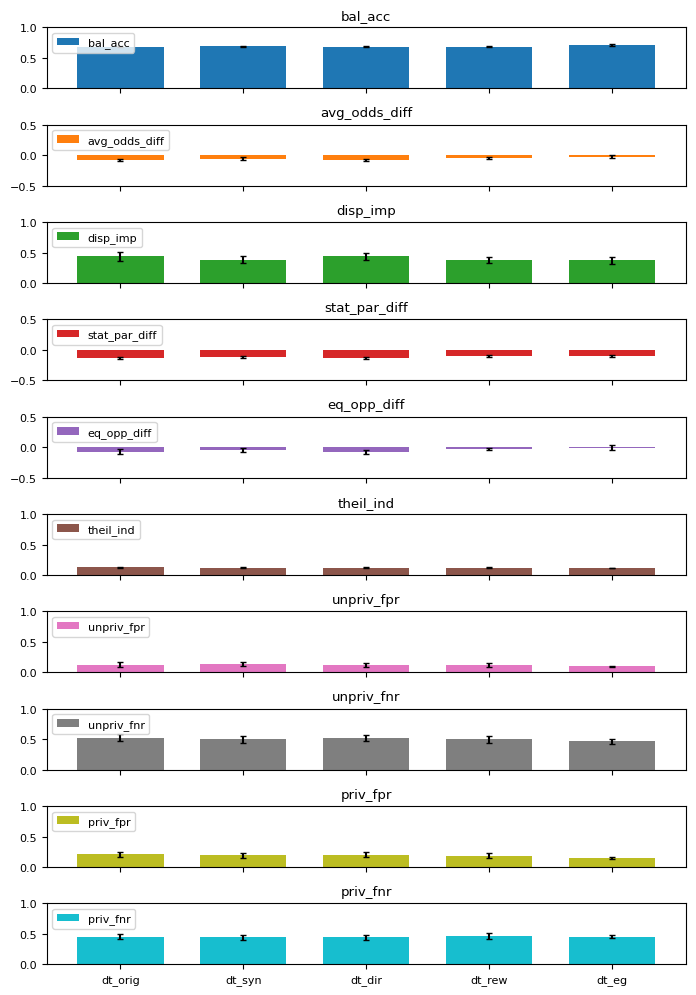

In [49]:
model_type=BASELINE
# Set up plotting options
plt.rcParams.update({'font.size': 8})  # Set global font size
pd.set_option('display.multi_sparse', False)

# Metrics and errors as lists of dictionaries
results = [orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean]
errors = [orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics]

# Classifier bias mitigators (for labels)
index = pd.Series(
    [model_type+'_orig', model_type+'_syn', model_type+'_dir', model_type+'_rew', model_type+'_eg'])

# Create DataFrame for metrics and error bars
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)

# Dynamically generate titles for all metrics in df
titles = list(df.columns)

# Plot fairness metrics with error bars
ax = df.plot.bar(
    yerr=df_error, 
    capsize=2, 
    rot=0, 
    subplots=True, 
    title=titles, 
    fontsize=8, 
    figsize=(7, 10),  # Reduced overall figure size
    legend=True,
    width=0.7  # Adjusted bar width to make bars closer
)

# Adjust Y-axis limits dynamically based on metric names
for i, subplot in enumerate(ax):
    metric = titles[i]
    if "fpr" in metric or "fnr" in metric:  # Subgroup-specific metrics
        subplot.set_ylim([0, 1])  # False positive/negative rates range from 0 to 1
    elif metric in ["bal_acc", "disp_imp", "theil_ind"]:  # General metrics
        subplot.set_ylim([0, 1])
    elif metric in ["avg_odds_diff", "stat_par_diff", "eq_opp_diff"]:  # Difference metrics
        subplot.set_ylim([-0.5, 0.5])  # Allow for negative values

    # Move legend inside the plot
    subplot.legend(loc='upper left', fontsize=8, frameon=True)

# Tight layout for better spacing
plt.tight_layout()
plt.show()

## Save Results

In [50]:
# List of method names corresponding to results/errors
method_names = ["orig", "transf", "dir", "rew", "eg"]

# Initialize a list to hold data for the DataFrame
fairness_data = []

# Populate the data list with metrics and errors
for method, metric, error in zip(method_names, results, errors):
    for key in metric.keys():
        fairness_data.append({
            "Method": method,
            "Metric": key,
            "Mean": metric[key][0],  # Assuming the metric values are single-item lists
            "Error": error[key][0]   # Assuming the error values are single-item lists
        })

# Create DataFrame from the data list
fairness_df = pd.DataFrame(fairness_data)

# File path with today's date
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./mia1_results/{ATTACK}_{DATASET}_fairness_metrics_{today}.csv"

# Save the DataFrame to CSV
fairness_df.to_csv(file_path, index=True)

print(f"File saved at: {file_path}")

File saved at: ./mia1_results/mia1_meps19_fairness_metrics_2024-12-31.csv


## Visualization of MIA results


### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [51]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [52]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          eg_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn'] + ['dir'] + ['rew'] + ['eg'], name='Classifier MIA Attacks')
#                   + ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

entire_dataset_mia_privacy_risk  \
Classifier MIA Attacks                                    
orig                                           0.540351   
syn                                            0.533743   
dir                                            0.540433   
rew                                            0.539533   
eg                                             0.530370   

                        entire_dataset_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                              
orig                                                     0.525542   
syn                                                      0.521940   
dir                                                      0.525780   
rew                                                      0.524732   
eg                                                       0.519838   

                        entire_dataset_label_1.0_mia_privacy_risk  \
Classifier MIA Attacks                                              
orig                                                     0.618456   
syn                                                      0.600229   
dir                                                      0.618274   
rew                                                      0.619205   
eg                                                       0.591535   

                        subpopulation_0.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.518203   
syn                                                         0.515690   
dir                                                         0.518046   
rew                                                         0.518121   
eg                                                          0.514666   

                        subpopulation_0.0_label_1.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.602383   
syn                                                         0.580082   
dir                                                         0.603577   
rew                                                         0.605899   
eg                                                          0.592856   

                        subpopulation_1.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.543431   
syn                                                         0.537732   
dir                                                         0.544819   
rew                                                         0.541667   
eg                                                          0.533382   

                        subpopulation_1.0_label_1.0_mia_privacy_risk  
Classifier MIA Attacks                                                
orig                                                        0.638309  
syn                                                         0.622043  
dir                                                         0.635808  
rew                                                         0.634564  
eg                                                          0.596476

In [53]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [54]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
                       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [55]:
df_groups

subpopulation_0.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.518203   
syn                                                         0.515690   
dir                                                         0.518046   
rew                                                         0.518121   
eg                                                          0.514666   

                        subpopulation_1.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.543431   
syn                                                         0.537732   
dir                                                         0.544819   
rew                                                         0.541667   
eg                                                          0.533382   

                        subpopulation_0.0_label_1.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.602383   
syn                                                         0.580082   
dir                                                         0.603577   
rew                                                         0.605899   
eg                                                          0.592856   

                        subpopulation_1.0_label_1.0_mia_privacy_risk  
Classifier MIA Attacks                                                
orig                                                        0.638309  
syn                                                         0.622043  
dir                                                         0.635808  
rew                                                         0.634564  
eg                                                          0.596476

<Axes: xlabel='Classifier MIA Attacks'>

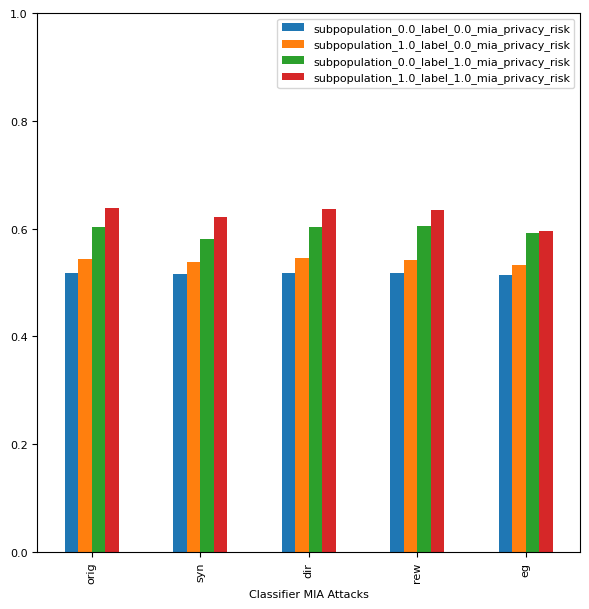

In [56]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [57]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew        eg
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.518203  0.51569   0.518046  0.518121  0.514666
subpopulation_1.0_label_0.0_mia_privacy_risk  0.543431  0.537732  0.544819  0.541667  0.533382
subpopulation_0.0_label_1.0_mia_privacy_risk  0.602383  0.580082  0.603577  0.605899  0.592856
subpopulation_1.0_label_1.0_mia_privacy_risk  0.638309  0.622043  0.635808  0.634564  0.596476


## Save Results

In [58]:
errors

[{'entire_dataset_mia_privacy_risk': 0.0023541113774943915,
  'entire_dataset_label_0.0_mia_privacy_risk': 0.0017031745243879803,
  'entire_dataset_label_1.0_mia_privacy_risk': 0.010235164735693246,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.00233939075416984,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.008890157906457297,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.003622293865086219,
  'subpopulation_1.0_label_1.0_mia_privacy_risk': 0.012154009508196409},
 {'entire_dataset_mia_privacy_risk': 0.003292264339803958,
  'entire_dataset_label_0.0_mia_privacy_risk': 0.0022685850002380297,
  'entire_dataset_label_1.0_mia_privacy_risk': 0.00967768514051469,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.0030411713125592134,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.012414189162589996,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.004719576137060989,
  'subpopulation_1.0_label_1.0_mia_privacy_risk': 0.009852287453953454},
 {'entire_dataset_mia_priv

In [59]:
# List of method names corresponding to results/errors
method_names = ["orig", "transf", "dir", "rew", "eg"]

# Initialize a list to hold data for the DataFrame
pr_data = []

# Populate the data list with metrics and errors
for method, metric, error in zip(method_names, results, errors):
    for key in metric.keys():
        pr_data.append({
            "Method": method,
            "Metric": key,
            "Mean Privacy Risk": metric[key],  # Privacy risk mean
            "Error": error[key]               # Privacy risk error
        })

# Create DataFrame from the data list
pr_df = pd.DataFrame(pr_data)

# File path with today's date
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./mia1_results/{ATTACK}_{DATASET}_mia_privacy_risks_metrics_{today}.csv"

# Save the DataFrame to CSV
pr_df.to_csv(file_path, index=True)

print(f"File saved at: {file_path}")

File saved at: ./mia1_results/mia1_meps19_mia_privacy_risks_metrics_2024-12-31.csv


# Main Bar Graph Visualization

In [60]:
# Subpopulations and fairness methods
subpopulations = {
    'subpopulation_0.0_label_0.0_mia_privacy_risk': "Unprivileged Unfavorable", 
    'subpopulation_0.0_label_1.0_mia_privacy_risk': "Unprivileged Favorable", 
    'subpopulation_1.0_label_0.0_mia_privacy_risk': "Privileged Unfavorable",
    'subpopulation_1.0_label_1.0_mia_privacy_risk': "Privileged Favorable"
}

fairness_methods = ["syn", "dir", "rew", "eg"]

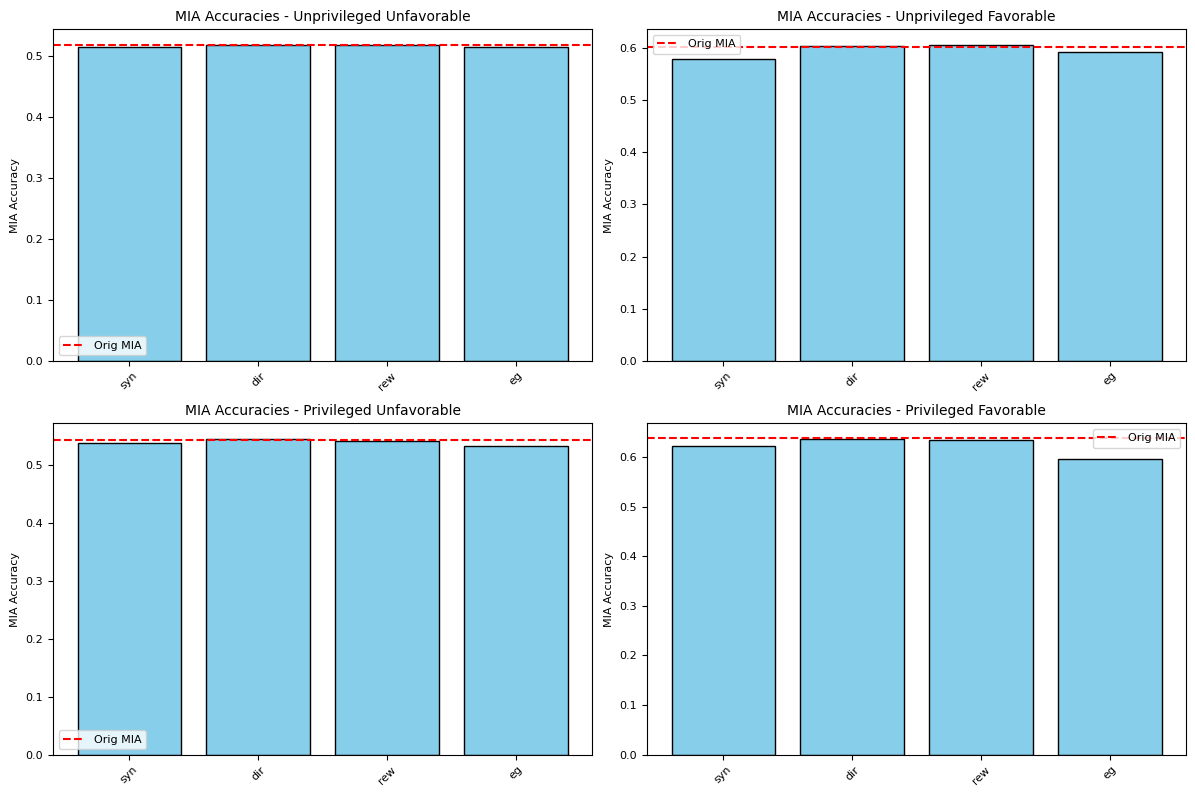

In [61]:
# Combine results into a list
all_results = [
    transf_mia_metrics_mean,
    dir_mia_metrics_mean,
    reweigh_mia_metrics_mean,
    eg_mia_metrics_mean
]

# Organize data for plotting
data = {subpopulations[key]: [results[key] for results in all_results] for key in subpopulations.keys()}
orig_values = orig_mia_metrics_mean

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
idx = 0

for key, value in subpopulations.items():
    accuracies = data[value]
    ax = axes[idx]
    
    # Plot bar chart (excluding 'orig')
    ax.bar(fairness_methods, accuracies, color='skyblue', edgecolor='black')
    
    # Add dashed line for 'orig' MIA accuracy
    ax.axhline(orig_values[key], color='red', linestyle='--', label='Orig MIA')
    
    # Title and labels
    ax.set_title(f"MIA Accuracies - {value}", fontsize=10)
    ax.set_ylabel("MIA Accuracy")
    ax.set_xticks(np.arange(len(fairness_methods)))
    ax.set_xticklabels(fairness_methods, rotation=45)
    ax.legend()
    
    idx = idx + 1

plt.tight_layout()
plt.show()

### Visualizing using novel technique

In [62]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [63]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in eg_mia_error_metrics.keys():
    for val in eg_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["eg", key.replace("_mia_attacker_advantage", ""), val])

In [64]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

Fairness                                           MIA  Privacy Risk
0       orig               entire_dataset_mia_privacy_risk      0.545546
1       orig               entire_dataset_mia_privacy_risk      0.539545
2       orig               entire_dataset_mia_privacy_risk      0.539229
3       orig               entire_dataset_mia_privacy_risk      0.536702
4       orig               entire_dataset_mia_privacy_risk      0.538661
..       ...                                           ...           ...
695       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.598258
696       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.577974
697       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.611964
698       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.605920
699       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.589662

[700 rows x 3 columns]

In [65]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

Fairness                                           MIA  Privacy Risk
0       orig               entire_dataset_mia_privacy_risk      0.545546
1       orig               entire_dataset_mia_privacy_risk      0.539545
2       orig               entire_dataset_mia_privacy_risk      0.539229
3       orig               entire_dataset_mia_privacy_risk      0.536702
4       orig               entire_dataset_mia_privacy_risk      0.538661
..       ...                                           ...           ...
695       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.598258
696       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.577974
697       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.611964
698       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.605920
699       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.589662

[500 rows x 3 columns]

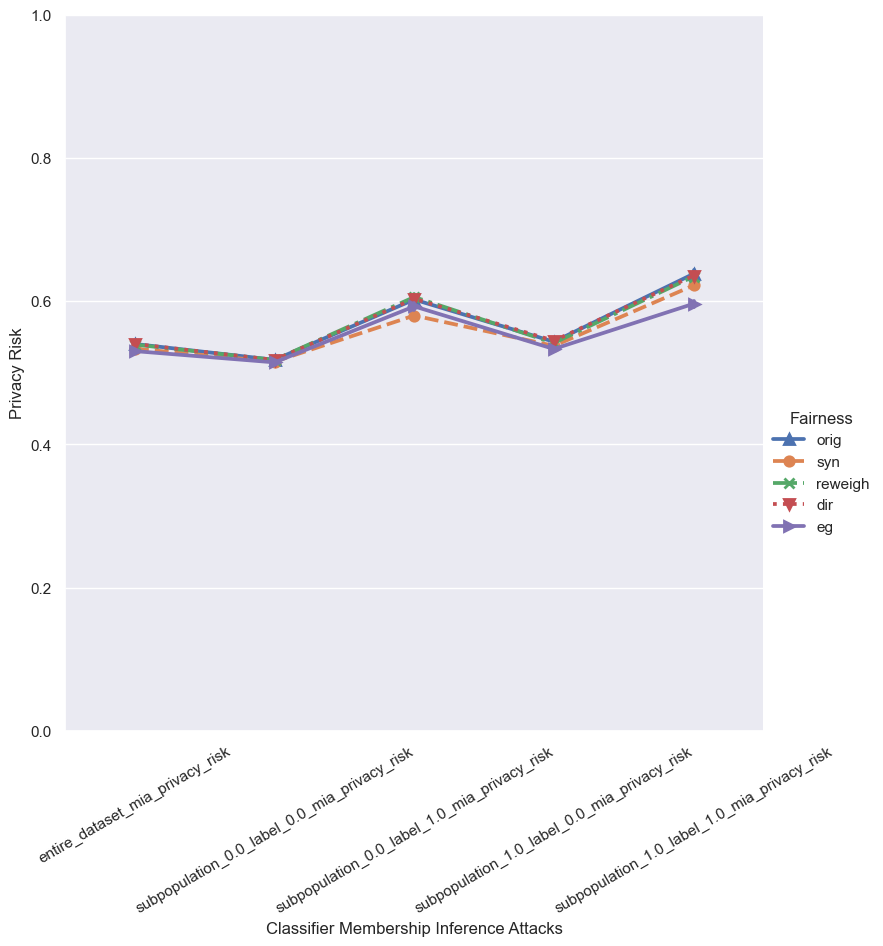

In [66]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [67]:
from sklearn.metrics import RocCurveDisplay, auc

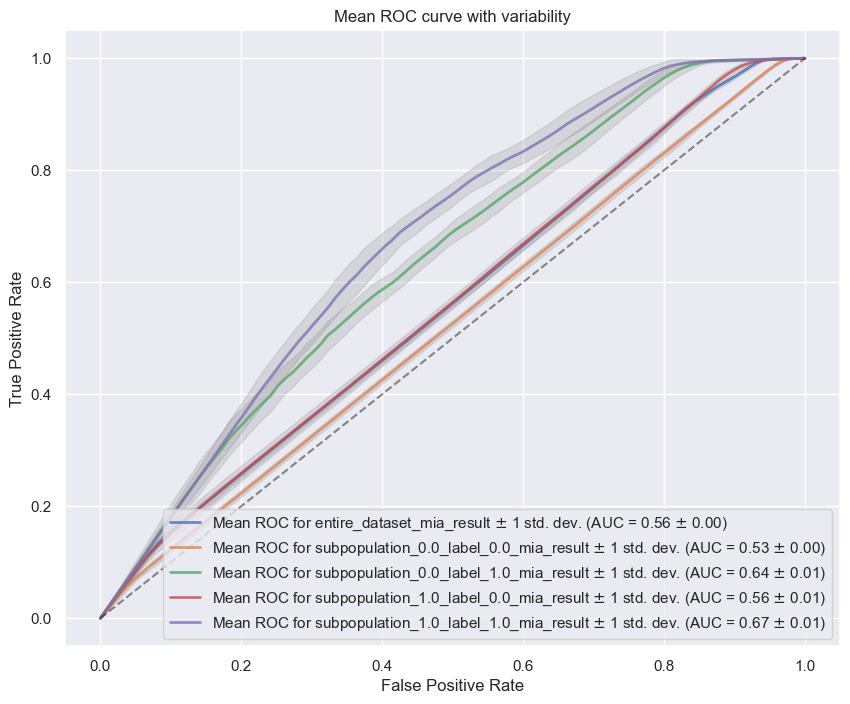

In [68]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", 
            "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", 
            "subpopulation_1.0_label_0.0_mia_result",
            "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.19
  Attacker advantage: 0.09
  Positive predictive value: 0.64
  Optimal thershold: -0.39788463656744893
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.18
  Attacker advantage: 0.08
  Positive predictive value: 0.62
  Optimal thershold: -0.471398241629977
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.16
  Attacker advantage: 0.08
  Positive predictive value: 0.61
  Optimal thershold: -0.9209510512707483
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 7915, Test = 7915
  AUC: 0.56
  Privacy Risk: 0.5

MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Dataset: Train = 2121, Test = 2091
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.22
  Attacker advantage: 0.07
  Positive predictive value: 0.65
  Optimal thershold: -0.07333585901473917
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Dataset: Train = 2082, Test = 2130
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.06
  Positive predictive value: 0.65
  Optimal thershold: -0.46815751181747584
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Dataset: Train = 2043, Test = 2169
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.16
  Attacker advantage: 0.08
  Positive predictive value: 0.61
  Optimal thershold: -0.15431098840970256
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Dataset: Tr

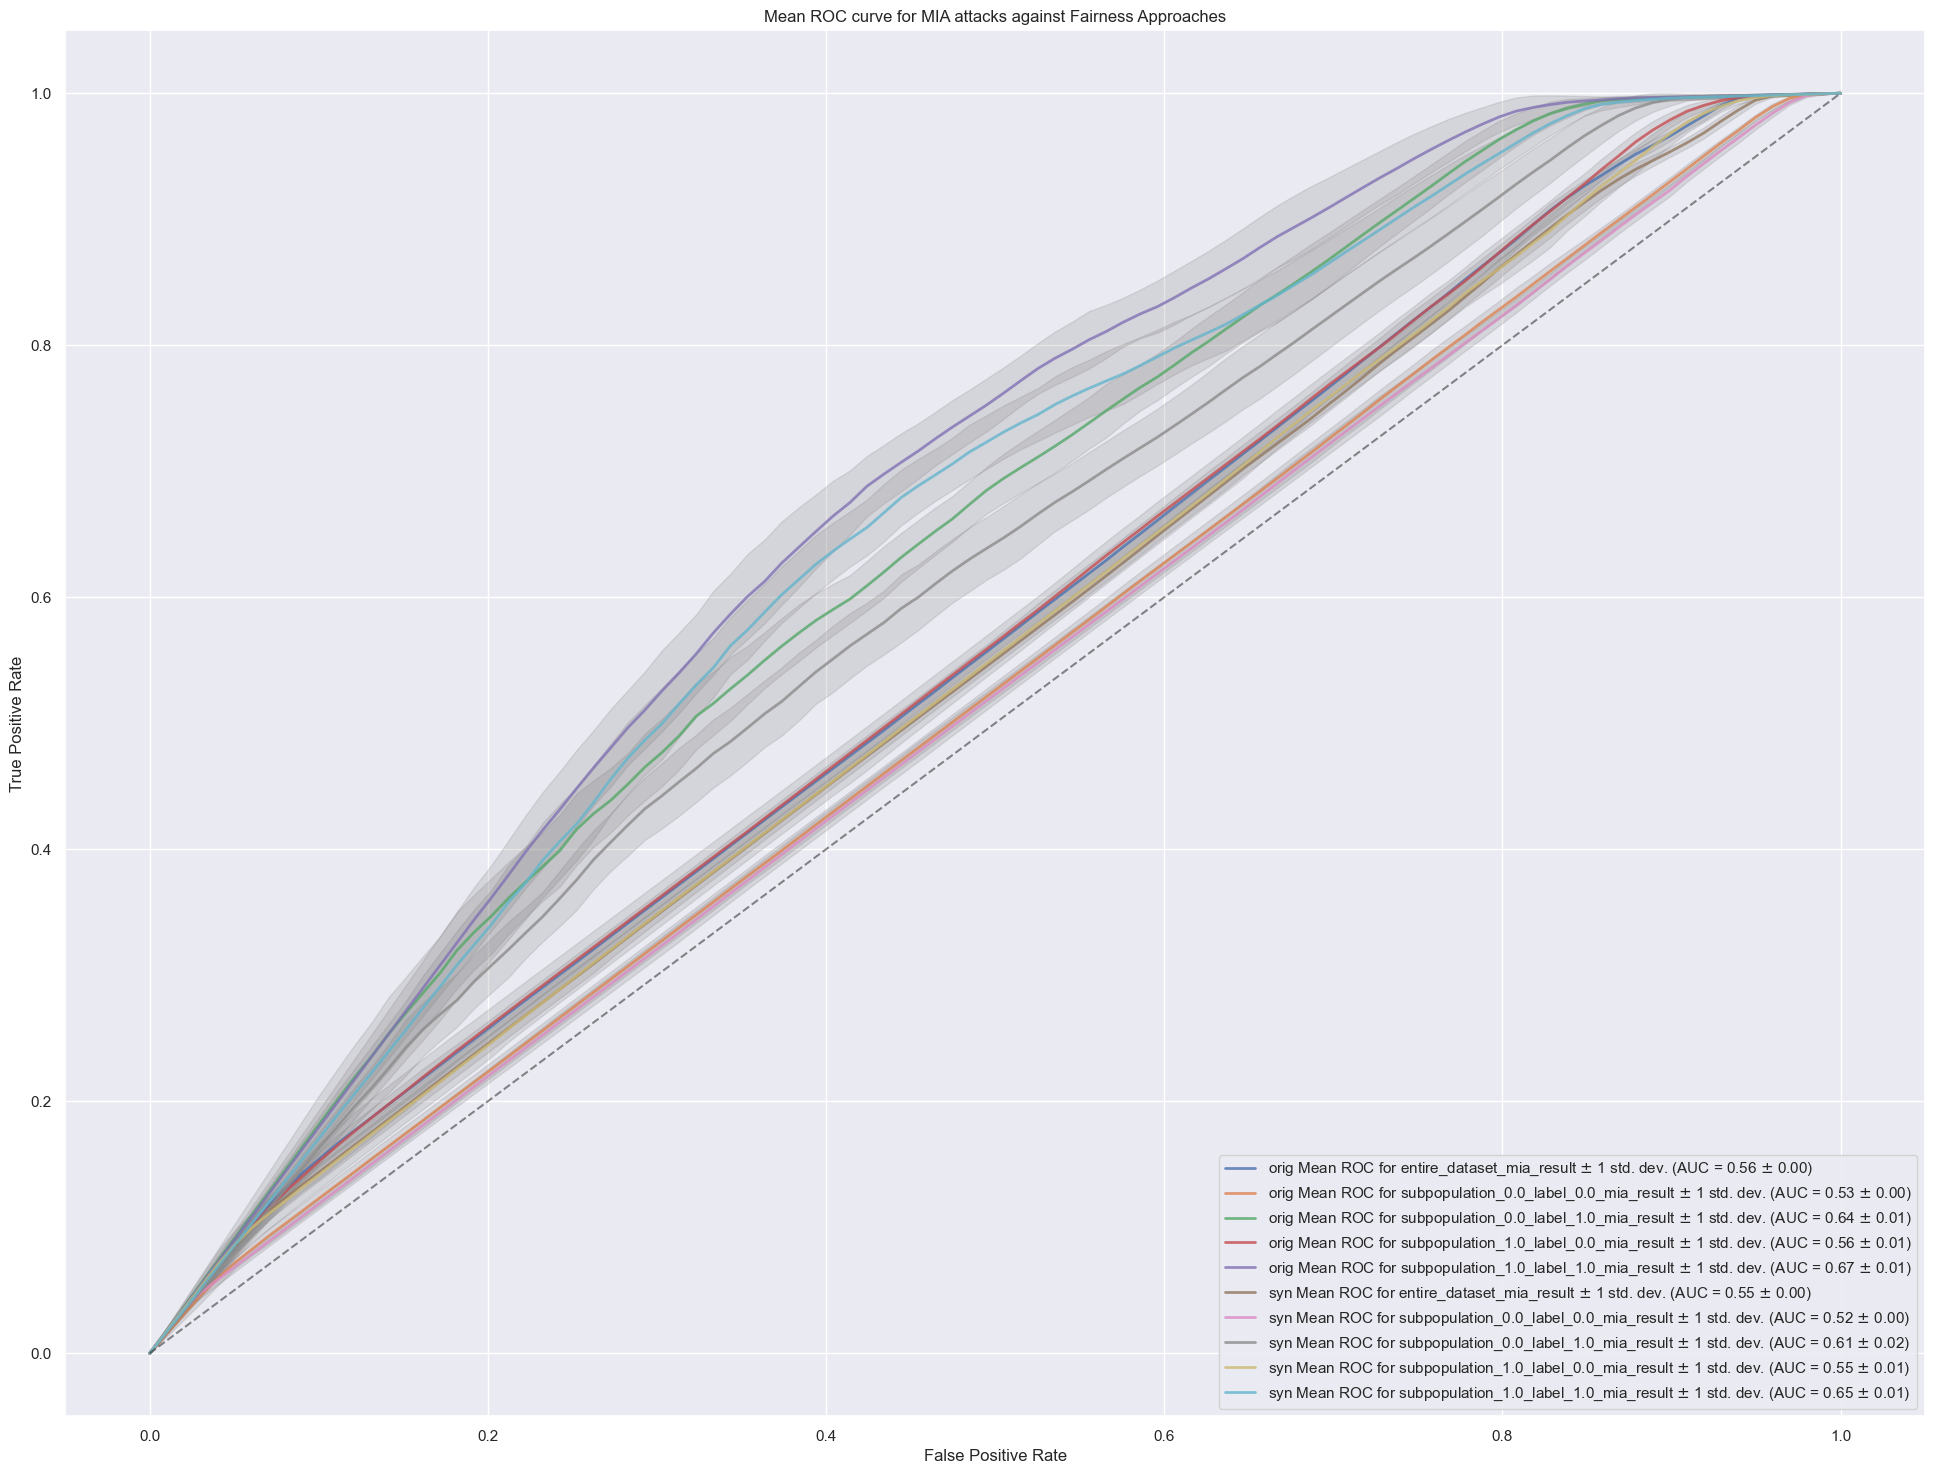

In [69]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics], ["orig", "syn"]): 
#                               dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", 
                "subpopulation_0.0_label_0.0_mia_result",
                "subpopulation_0.0_label_1.0_mia_result", 
                "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            print(mia_res)
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

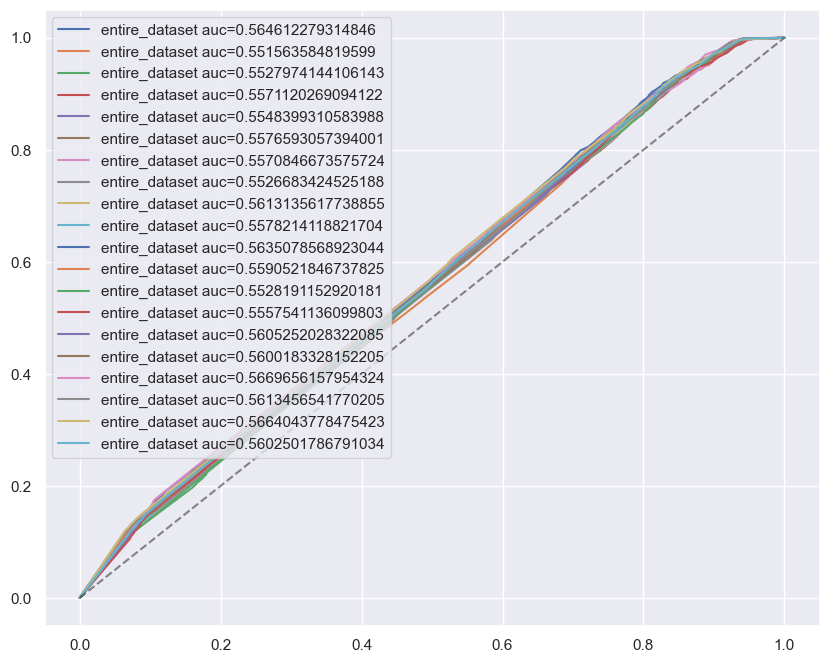

In [70]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [71]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("mia_auc")}

In [72]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

entire_dataset_mia_auc  \
Classifier MIA Attacks                           
orig                                  0.558706   
syn                                   0.548278   
dir                                   0.559141   
rew                                   0.557706   
egr                                   0.524661   

                        entire_dataset_label_0.0_mia_auc  \
Classifier MIA Attacks                                     
orig                                            0.536273   
syn                                             0.530886   
dir                                             0.537079   
rew                                             0.535110   
egr                                             0.516270   

                        entire_dataset_label_1.0_mia_auc  \
Classifier MIA Attacks                                     
orig                                            0.656647   
syn                                             0.630245   
dir                                             0.656035   
rew                                             0.657493   
egr                                             0.619419   

                        subpopulation_0.0_label_0.0_mia_auc  \
Classifier MIA Attacks                                        
orig                                               0.525529   
syn                                                0.521548   
dir                                                0.525701   
rew                                                0.525357   
egr                                                0.510566   

                        subpopulation_0.0_label_1.0_mia_auc  \
Classifier MIA Attacks                                        
orig                                               0.640084   
syn                                                0.607917   
dir                                                0.641459   
rew                                                0.644041   
egr                                                0.617391   

                        subpopulation_1.0_label_0.0_mia_auc  \
Classifier MIA Attacks                                        
orig                                               0.560410   
syn                                                0.550241   
dir                                                0.562734   
rew                                                0.554956   
egr                                                0.529757   

                        subpopulation_1.0_label_1.0_mia_auc  
Classifier MIA Attacks                                       
orig                                               0.671649  
syn                                                0.648887  
dir                                                0.669386  
rew                                                0.669107  
egr                                                0.621496

<Axes: xlabel='Classifier MIA Attacks'>

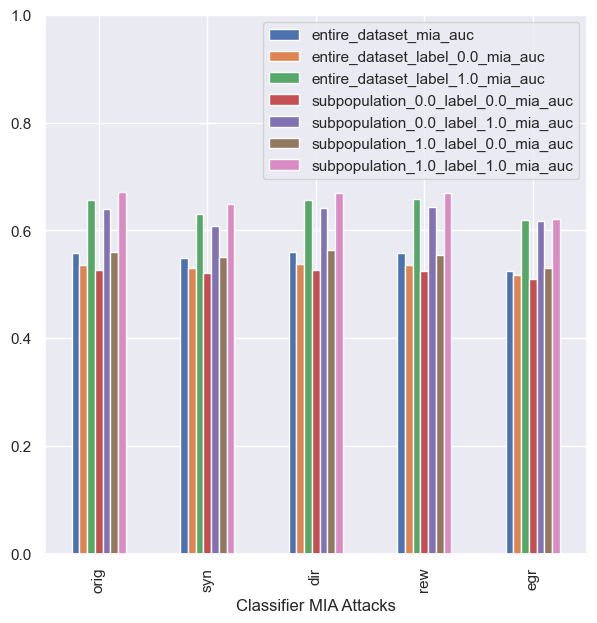

In [73]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [74]:
# Creating data structures to plot point categorical plot from seaborn

In [75]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [76]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.09109286165508534],
 ['orig', 'entire_dataset', 0.07909033480732786],
 ['orig', 'entire_dataset', 0.07845862286797223],
 ['orig', 'entire_dataset', 0.07340492735312698],
 ['orig', 'entire_dataset', 0.0773215413771321],
 ['orig', 'entire_dataset', 0.07466835123183824],
 ['orig', 'entire_dataset', 0.07289955780164248],
 ['orig', 'entire_dataset', 0.0778269109286166],
 ['orig', 'entire_dataset', 0.08237523689197734],
 ['orig', 'entire_dataset', 0.08313329121920399],
 ['orig', 'entire_dataset', 0.08679722046746685],
 ['orig', 'entire_dataset', 0.08060644346178136],
 ['orig', 'entire_dataset', 0.07668982943777636],
 ['orig', 'entire_dataset', 0.0812381554011371],
 ['orig', 'entire_dataset', 0.07921667719519898],
 ['orig', 'entire_dataset', 0.08250157927984847],
 ['orig', 'entire_dataset', 0.08528111181301323],
 ['orig', 'entire_dataset', 0.08098547062539474],
 ['orig', 'entire_dataset', 0.08692356285533798],
 ['orig', 'entire_dataset', 0.08351231838281747],
 ['

In [77]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

Fairness                          MIA  attacker_advantage
0       orig               entire_dataset            0.091093
1       orig               entire_dataset            0.079090
2       orig               entire_dataset            0.078459
3       orig               entire_dataset            0.073405
4       orig               entire_dataset            0.077322
..       ...                          ...                 ...
695      egr  subpopulation_1.0_label_1.0            0.196515
696      egr  subpopulation_1.0_label_1.0            0.155948
697      egr  subpopulation_1.0_label_1.0            0.223929
698      egr  subpopulation_1.0_label_1.0            0.211839
699      egr  subpopulation_1.0_label_1.0            0.179325

[700 rows x 3 columns]

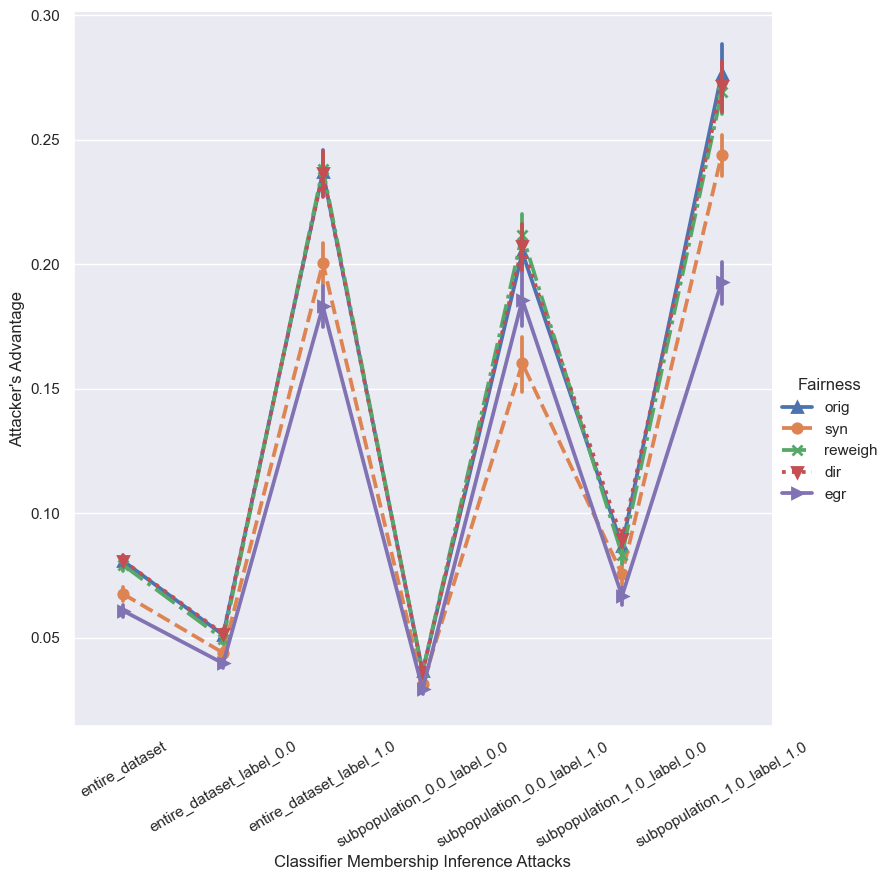

In [78]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


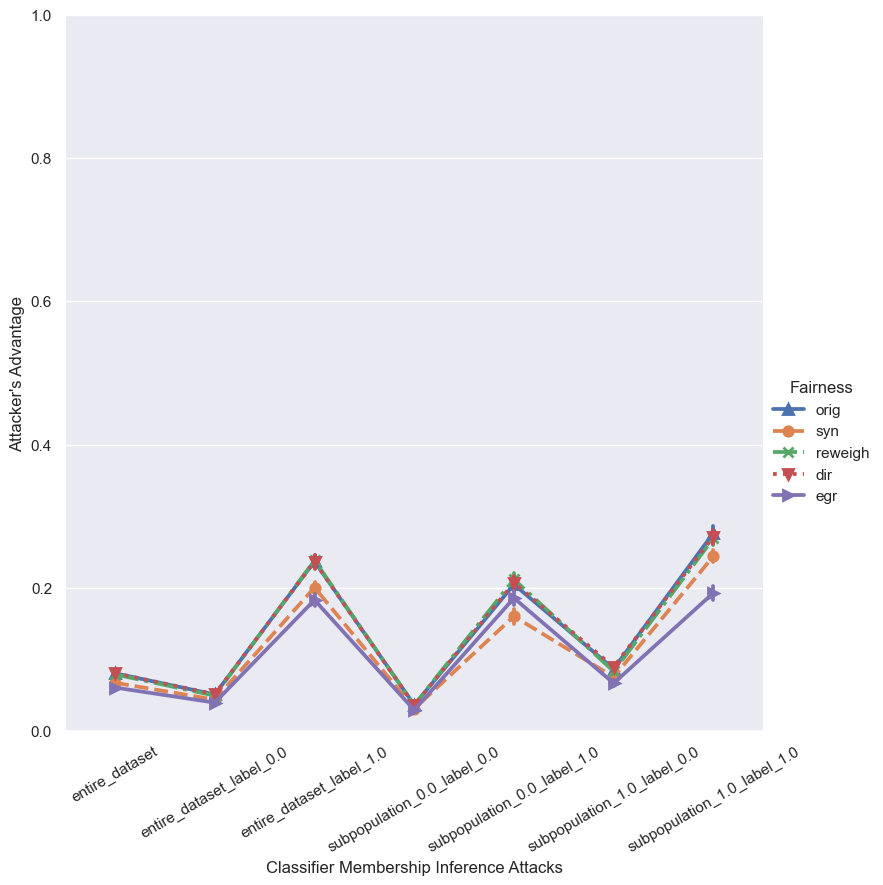

In [79]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [80]:
pd.DataFrame(orig_mia_metrics_att_ad)

entire_dataset_mia_attacker_advantage  \
0                                0.091093   
1                                0.079090   
2                                0.078459   
3                                0.073405   
4                                0.077322   
5                                0.074668   
6                                0.072900   
7                                0.077827   
8                                0.082375   
9                                0.083133   
10                               0.086797   
11                               0.080606   
12                               0.076690   
13                               0.081238   
14                               0.079217   
15                               0.082502   
16                               0.085281   
17                               0.080985   
18                               0.086924   
19                               0.083512   

    entire_dataset_label_0.0_mia_attacker_advantage  \
0                                          0.052862   
1                                          0.054564   
2                                          0.048269   
3                                          0.046474   
4                                          0.048213   
5                                          0.051351   
6                                          0.052458   
7                                          0.047227   
8                                          0.056581   
9                                          0.044755   
10                                         0.057086   
11                                         0.052652   
12                                         0.051708   
13                                         0.045933   
14                                         0.051251   
15                                         0.051867   
16                                         0.052965   
17                                         0.053497   
18                                         0.052594   
19                                         0.049361   

    entire_dataset_label_1.0_mia_attacker_advantage  \
0                                          0.277539   
1                                          0.225505   
2                                          0.227433   
3                                          0.215013   
4                                          0.233831   
5                                          0.231178   
6                                          0.211625   
7                                          0.232531   
8                                          0.230160   
9                                          0.271495   
10                                         0.247087   
11                                         0.223695   
12                                         0.193726   
13                                         0.221016   
14                                         0.240618   
15                                         0.252930   
16                                         0.261016   
17                                         0.244111   
18                                         0.255348   
19                                         0.242386   

    subpopulation_0.0_label_0.0_mia_attacker_advantage  \
0                                            0.041538    
1                                            0.035423    
2                                            0.034190    
3                                            0.032755    
4                                            0.034930    
5                                            0.036717    
6                                            0.034478    
7                                            0.032005    
8                                            0.043643    
9                                            0.032002    
10                                           0.046715    
11                                           0.035

In [81]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [82]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

entire_dataset_mia_attacker_advantage  \
Classifier MIA Attacks                                          
orig                                                 0.080701   
syn                                                  0.067486   
dir                                                  0.080865   
rew                                                  0.079065   
egr                                                  0.060739   

                        entire_dataset_label_0.0_mia_attacker_advantage  \
Classifier MIA Attacks                                                    
orig                                                           0.051083   
syn                                                            0.043881   
dir                                                            0.051560   
rew                                                            0.049464   
egr                                                            0.039676   

                        entire_dataset_label_1.0_mia_attacker_advantage  \
Classifier MIA Attacks                                                    
orig                                                           0.236912   
syn                                                            0.200458   
dir                                                            0.236548   
rew                                                            0.238410   
egr                                                            0.183070   

                        subpopulation_0.0_label_0.0_mia_attacker_advantage  \
Classifier MIA Attacks                                                       
orig                                                             0.036405    
syn                                                              0.031381    
dir                                                              0.036093    
rew                                                              0.036241    
egr                                                              0.029332    

                        subpopulation_0.0_label_1.0_mia_attacker_advantage  \
Classifier MIA Attacks                                                       
orig                                                             0.204765    
syn                                                              0.160164    
dir                                                              0.207154    
rew                                                              0.211798    
egr                                                              0.185712    

                        subpopulation_1.0_label_0.0_mia_attacker_advantage  \
Classifier MIA Attacks                                                       
orig                                                             0.086861    
syn                                                              0.075464    
dir                                                              0.089639    
rew                                                              0.083334    
egr                                                              0.066763    

                        subpopulation_1.0_label_1.0_mia_attacker_advantage  
Classifier MIA Attacks                                                      
orig                                                             0.276618   
syn                                                              0.244085   
dir                                                              0.271616   
rew                                                              0.269129   
egr                                                              0.192952

<Axes: xlabel='Classifier MIA Attacks'>

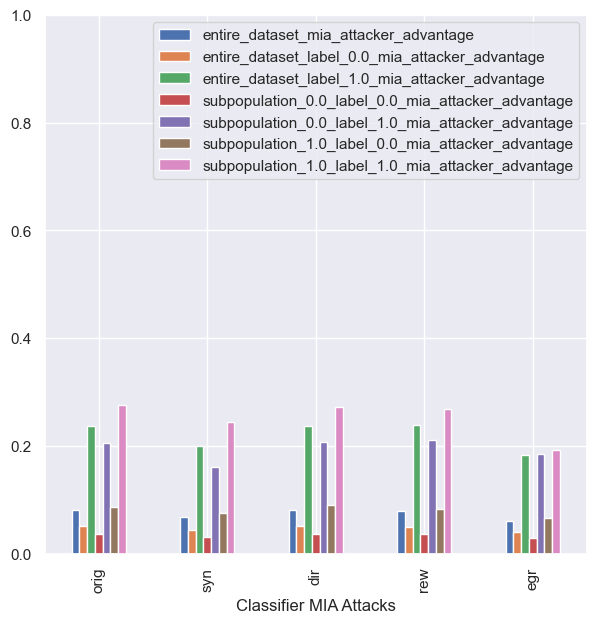

In [83]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [84]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("mia_ppv")}

In [85]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.640604467805519],
 ['orig', 'entire_dataset', 0.6160046056419113],
 ['orig', 'entire_dataset', 0.6115702479338843],
 ['orig', 'entire_dataset', 0.6467702371218316],
 ['orig', 'entire_dataset', 0.6163594470046082],
 ['orig', 'entire_dataset', 0.613354873451804],
 ['orig', 'entire_dataset', 0.6346704871060173],
 ['orig', 'entire_dataset', 0.6229290921139827],
 ['orig', 'entire_dataset', 0.6163682864450128],
 ['orig', 'entire_dataset', 0.6157965194109772],
 ['orig', 'entire_dataset', 0.6446991404011462],
 ['orig', 'entire_dataset', 0.6336436170212766],
 ['orig', 'entire_dataset', 0.6152787336545079],
 ['orig', 'entire_dataset', 0.6077134986225896],
 ['orig', 'entire_dataset', 0.6171557562076749],
 ['orig', 'entire_dataset', 0.624249699879952],
 ['orig', 'entire_dataset', 0.6231818181818182],
 ['orig', 'entire_dataset', 0.6496902959394356],
 ['orig', 'entire_dataset', 0.6508710801393728],
 ['orig', 'entire_dataset', 0.6223958333333334],
 ['orig', 'entire_datas

In [86]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

Fairness                          MIA       PPV
0       orig               entire_dataset  0.640604
1       orig               entire_dataset  0.616005
2       orig               entire_dataset  0.611570
3       orig               entire_dataset  0.646770
4       orig               entire_dataset  0.616359
..       ...                          ...       ...
695      egr  subpopulation_1.0_label_1.0  0.666667
696      egr  subpopulation_1.0_label_1.0  0.661290
697      egr  subpopulation_1.0_label_1.0  0.714286
698      egr  subpopulation_1.0_label_1.0  0.657143
699      egr  subpopulation_1.0_label_1.0  0.594340

[700 rows x 3 columns]

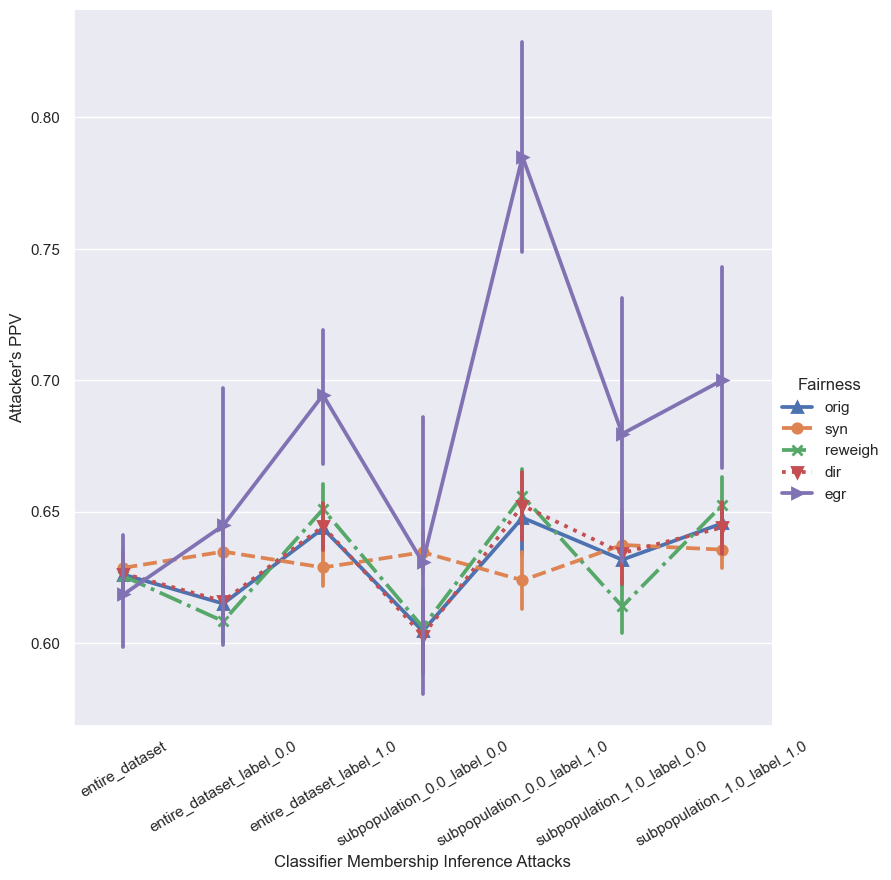

In [87]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )
